# Task 5 - Neural Machine Translation

In this task we were asked to build an attention based Neural Machine Translation model following [this ](https://www.tensorflow.org/tutorials/text/nmt_with_attention)tutorial. The tutorial uses a spanish english dataset. We have chosen to go on with German-English dataset. The dataset consists of 216k pairs of sentences but we have done the training using only 40k sentence pairs.


The model consists of 3 building blocks

* The encoder part
* The attention layer
* The decoder part

the encoder and decoder part stays the same and we have experimented 3 different types of attention mechanisms

* Bahdanau Attention
* Loungs Multiplicative type attention
* Dot Product attention

The encoder part encodes the given sentence and converts that into a context from the context the attention model builds an attention matrix and the decoder takes in the attention matrix as well as the encoder outputs and hidden states and gives the output sentences.

The loss plots for all three layers as well as its legends are given below

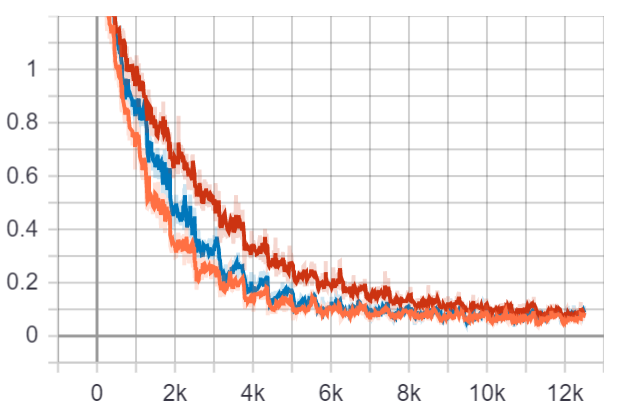 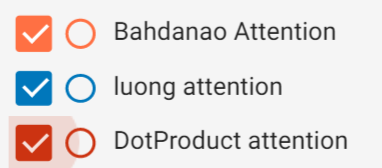

It can be observed from the above plots that Bahdanau's Attention Mechanism gave comparitively better convergence initially due to the increased number of trainable parameters.

In [37]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [38]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
file_path = "/content/drive/My Drive/Deep Learning Assignments/Final Project/deu.txt"

In [180]:
logdir = os.path.join("logs")
writer = tf.summary.create_file_writer(os.path.join(logdir,"DotProduct attention"))

In [134]:
def unicode_to_ascii(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')
   
def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z?.!,¿ÜüÖöÄöß]+", " ", w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [135]:
en_sentence = u"Hi."
de_sentence = u"Grüß Gott!"

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(de_sentence).encode('utf-8'))

<start> hi . <end>
b'<start> gru\xc3\x9f gott ! <end>'


In [136]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

en,de,_ = create_dataset(file_path, None)
print(en[5])
print(de[5])

print(len(en))

<start> wow ! <end>
<start> potzdonner ! <end>
217032


In [138]:
def tokenize(lang):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = " ")
  tokenizer.fit_on_texts(lang)
  tensor = tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, tokenizer

In [139]:
def load_dataset(path, num_examples=None):
  inp_lang,target_lang,_ = create_dataset(path,num_examples)
  inp_tensor,inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor,target_lang_tokenizer = tokenize(target_lang)
  return inp_tensor,target_tensor,inp_lang_tokenizer,target_lang_tokenizer

In [140]:
num_examples = 50000
inp_tensor,target_tensor,inp_lang_tokenizer,target_lang_tokenizer = load_dataset(file_path,num_examples=num_examples)

max_len_target,max_len_inp = target_tensor.shape[1],inp_tensor.shape[1]
print(inp_tensor[0],target_tensor[0])

[ 1 39  3  2  0  0  0  0  0  0  0] [  1 158   3   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


In [141]:
inp_tensor_train,inp_tensor_val,target_tensor_train,target_tensor_val = train_test_split(inp_tensor,target_tensor,test_size = 0.2)

In [142]:
def convert(lang,tensor):
  for t in tensor:
    if t!=0:
      print("{} ==> {}".format(t,lang.index_word[t]))

print("input sentence........")
convert(inp_lang_tokenizer,inp_tensor_train[0])
print()
print("target sequence.......")
convert(target_lang_tokenizer,target_tensor_train[0])

input sentence........
1 ==> <start>
25 ==> can
34 ==> she
58 ==> come
38 ==> in
119 ==> time
7 ==> ?
2 ==> <end>

target sequence.......
1 ==> <start>
30 ==> kann
8 ==> sie
1249 ==> punktlich
113 ==> kommen
7 ==> ?
2 ==> <end>


# The fun part begins here

In [143]:
buffer_size = len(inp_tensor_train)
batch_size = 64
steps_per_epoch = buffer_size//batch_size
embedding_dims = 256
units = 1024
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(target_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((inp_tensor_train,target_tensor_train)).shuffle(buffer_size)
dataset = dataset.batch(batch_size,drop_remainder = True)

In [144]:
inp_batch,target_batch = next(iter(dataset))
print(inp_batch,target_batch)

tf.Tensor(
[[   1   16   46  138  279    3    2    0    0    0    0]
 [   1   16   46    9   87    3    2    0    0    0    0]
 [   1   35   25   12  293    6    3    2    0    0    0]
 [   1    4   28 1869    3    2    0    0    0    0    0]
 [   1   10   92   12   37   15  221    3    2    0    0]
 [   1    5  228   56 2264    3    2    0    0    0    0]
 [   1 1802   56 4124    3    2    0    0    0    0    0]
 [   1    5   21    9  442    3    2    0    0    0    0]
 [   1   46   10  433    7    2    0    0    0    0    0]
 [   1    5    8 3331    3    2    0    0    0    0    0]
 [   1    4   18    9  148 1358   56  692    3    2    0]
 [   1   40   17   39    3    2    0    0    0    0    0]
 [   1   54   72   56   22 1410    3    2    0    0    0]
 [   1    5 2491   10    3    2    0    0    0    0    0]
 [   1   67   11   22  485    7    2    0    0    0    0]
 [   1   13  181  631    3    2    0    0    0    0    0]
 [   1  504   10    3    2    0    0    0    0    0    0]
 [ 

In [169]:
class Encoder(tf.keras.Model):
  def __init__(self,embedding_dims,vocab_size,enc_units,batch_size):
    super(Encoder,self).__init__()
    self.batch_size = batch_size
    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dims)
    self.encoder_units = enc_units
    self.gru = tf.keras.layers.GRU(self.encoder_units,return_sequences=True,
                                   return_state = True,recurrent_initializer = 'glorot_uniform')
  def call(self,x,hidden):
      x = self.embedding(x)
      output,state = self.gru(x,initial_state = hidden)
      return output,state
  def initialize_hidden_state(self):
      return tf.zeros((self.batch_size,self.encoder_units))
    

In [170]:
encoder = Encoder(embedding_dims,vocab_inp_size,units,batch_size)
sample_hidden = encoder.initialize_hidden_state()

sample_output,sample_hidden = encoder(inp_batch,sample_hidden)

print(sample_output.shape,sample_hidden.shape)

(64, 11, 1024) (64, 1024)


## Bahdanou's additive style attention mechanism

We have followed the same steps from the tutorial to build Bahdanau's attention layer. The following image gives the attention plot for a model trained with Bahdanau's attention mechanism.

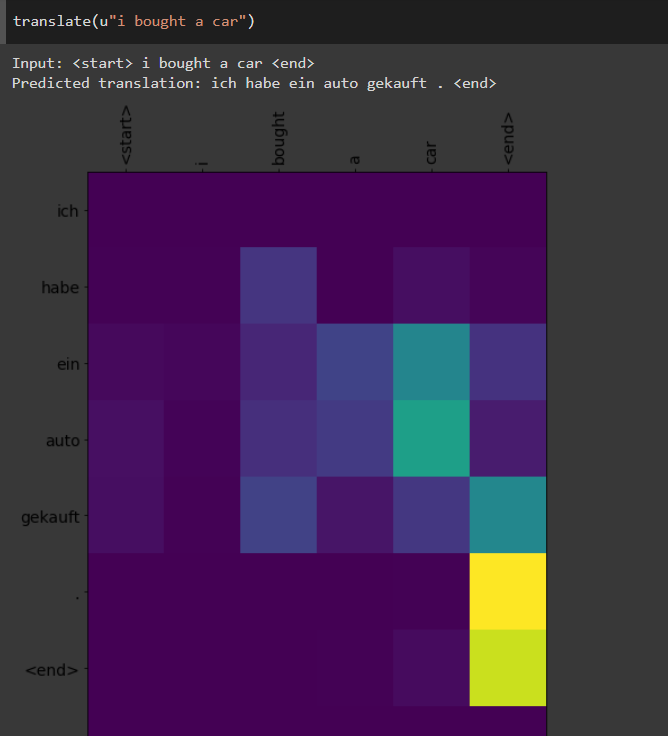

from the above figure we can observe that there is a sparse distribution of the attention weights throughout the entire context.

In [171]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [172]:
attention_layer = BahdanauAttention(10)
context,attention = attention_layer(sample_hidden,sample_output)

print(context.shape,attention.shape)

(64, 1024) (64, 11, 1)


## Luongs's multiplicative style attention mechanism

Luong's Multiplicative style attention mechanism has only one trainable parameter compared to Bahdanau mechanism which has 2 trainable parameters involved. The following figure gives the attention matrix of a model trained with Loung's attention mechanism

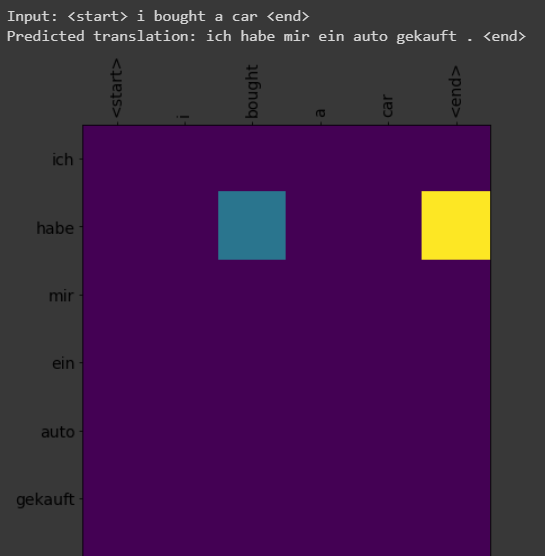

unlike soft attention that we observed in Bahdanau we see that the main word of the context (Bought) has a higher attention compared to the other words.

In [173]:
class LuongMultiplicativeAttention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(LuongMultiplicativeAttention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(max_len_inp)
  
  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.reduce_sum( tf.multiply(values,query_with_time_axis), 2))
    score = tf.expand_dims(score,2)
    attention_weights = tf.nn.softmax(score,axis = 1)
    context = attention_weights*values
    context = tf.reduce_sum(context, axis=1)
    return context, attention_weights

In [174]:
attention_layer = LuongMultiplicativeAttention(10)
context,attention = attention_layer(sample_hidden,sample_output)

print(context.shape,attention.shape)

(64, 1024) (64, 11, 1)


## Dot Product Attention

The dot product attention is simply a vector dot product of query and the values vector. It does not have any trainable parameters like the other two attention models
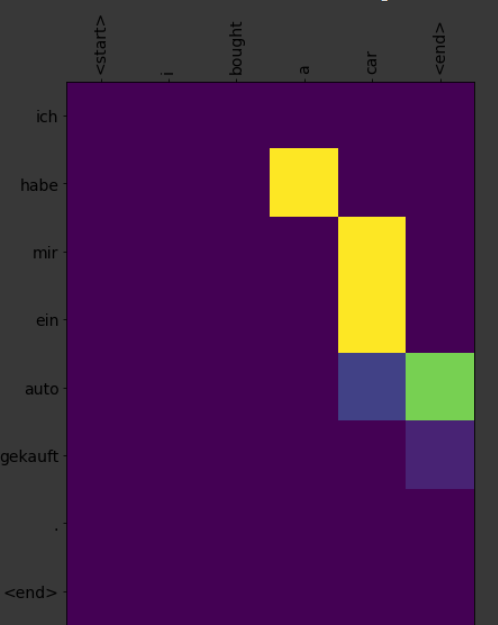

The attention matrix is densly distributed across the last word of the input sentence.

In [175]:
class DotProductAttention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(DotProductAttention,self).__init__()
  
  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = (tf.reduce_sum( tf.multiply(values,query_with_time_axis), 2))
    score = tf.expand_dims(score,2)
    attention_weights = tf.nn.softmax(score,axis = 1)
    context = attention_weights*values
    context = tf.reduce_sum(context, axis=1)
    return context, attention_weights

In [176]:
attention_layer = DotProductAttention(10)
context,attention = attention_layer(sample_hidden,sample_output)

print(context.shape,attention.shape)

(64, 1024) (64, 11, 1)


In [177]:
class Decoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dims,dec_units,batch_size):
    super(Decoder,self).__init__()
    self.batch_size = batch_size
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dims)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = "glorot_uniform")
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = DotProductAttention(self.dec_units)

  def call(self,x,hidden,enc_output):
    context_vector,attention_weights = self.attention(hidden,enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector,1),x],axis = -1)
    output,state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

In [178]:
decoder = Decoder(vocab_tar_size, embedding_dims, units, batch_size)

In [179]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

def loss_function(real,preds):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss = loss_fn(real,preds)
  mask = tf.cast(mask,dtype=loss.dtype)
  loss *= mask
  return tf.reduce_mean(loss)

In [181]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"DotPdtChkpt")

checkpoint= tf.train.Checkpoint(optimizer=optimizer,encoder= encoder,decoder=decoder)

In [182]:
def training_step(inp,target,enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output,enc_hidden = encoder(inp,enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_lang_tokenizer.word_index["<start>"]]*batch_size,1)

    for t in range (1,target.shape[1]):
      predictions,dec_hidden,_  =  decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)
  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [183]:
EPOCHS = 20
step = 0
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    step += 1
    batch_loss = training_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    with writer.as_default():
      tf.summary.scalar("loss",batch_loss.numpy(),step=step)

    if batch % 100 == 0:
      print('Epoch {}  step {} Batch {} Loss {:.4f}'.format(epoch + 1, step,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 5 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1  step 1 Batch 0 Loss 3.0187
Epoch 1  step 101 Batch 100 Loss 1.5064
Epoch 1  step 201 Batch 200 Loss 1.3327
Epoch 1  step 301 Batch 300 Loss 1.3288
Epoch 1  step 401 Batch 400 Loss 1.2039
Epoch 1  step 501 Batch 500 Loss 1.1973
Epoch 1  step 601 Batch 600 Loss 1.0981
Epoch 1 Loss 1.3365
Time taken for 1 epoch 154.31206512451172 sec

Epoch 2  step 626 Batch 0 Loss 1.0408
Epoch 2  step 726 Batch 100 Loss 0.9772
Epoch 2  step 826 Batch 200 Loss 0.9980
Epoch 2  step 926 Batch 300 Loss 0.9900
Epoch 2  step 1026 Batch 400 Loss 0.9580
Epoch 2  step 1126 Batch 500 Loss 0.8933
Epoch 2  step 1226 Batch 600 Loss 0.8996
Epoch 2 Loss 0.9795
Time taken for 1 epoch 150.11488938331604 sec

Epoch 3  step 1251 Batch 0 Loss 0.8661
Epoch 3  step 1351 Batch 100 Loss 0.8087
Epoch 3  step 1451 Batch 200 Loss 0.8354
Epoch 3  step 1551 Batch 300 Loss 0.8741
Epoch 3  step 1651 Batch 400 Loss 0.7806
Epoch 3  step 1751 Batch 500 Loss 0.7355
Epoch 3  step 1851 Batch 600 Loss 0.7081
Epoch 3 Loss 0.7947
Time

In [184]:
def evaluate(sentence):
  attention_plot = np.zeros((max_len_target, max_len_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_len_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''
  # inp_lang_tokenizer,target_lang_tokenizer
  # max_len_target,max_len_inp

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']], 0)

  for t in range(max_len_target):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_lang_tokenizer.index_word[predicted_id] + ' '

    if target_lang_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [191]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  print(attention)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [186]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [187]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> i bought a car <end>
Predicted translation: ich habe mir ein auto gekauft . <end> 
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 6.36991719e-33]
 [9.68931596e-26 2.04002625e-29 8.72063109e-20 9.99991417e-01
  8.57878058e-06 6.28539638e-08]
 [2.34631364e-20 3.02571170e-24 1.92352838e-19 2.48891662e-12
  9.99988437e-01 1.13532178e-05]
 [2.89291558e-31 1.56236909e-37 4.78560681e-26 1.99459869e-15
  9.99006689e-01 9.93074034e-04]
 [2.44273738e-25 7.22005895e-33 3.03614482e-23 1.96199597e-15
  1.94998950e-01 7.93804467e-01]
 [1.09807224e-11 1.49610354e-17 2.57754186e-13 1.28001254e-09
  1.09395332e-05 1.01447776e-01]
 [1.75526051e-18 1.47358539e-25 5.34826947e-24 8.17325583e-18
  6.19728802e-09 5.88861985e-05]
 [6.97446544e-28 4.64397217e-37 2.38519164e-30 2.28604368e-21
  4.03727768e-07 1.67505368e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


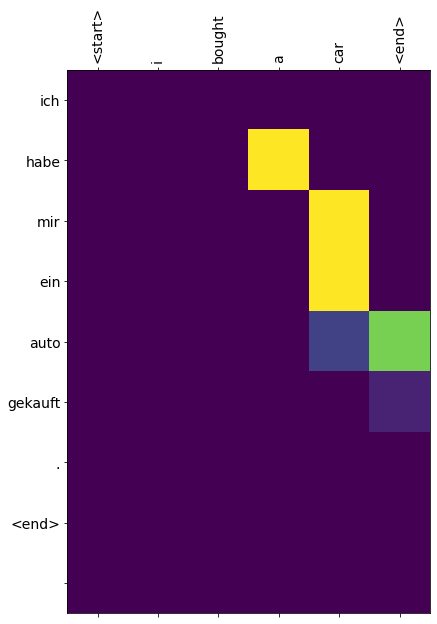

In [192]:
translate(u"i bought a car")

## Q & A

**Which parts of the sentence are used as a token? Each character, each word, or are some words split up?**

This task follows a word level tokenization and the words with punctuations in between them like "isn't, can't" etc are split such that isn is a seperate token and t is a seperate token.

**Do the same tokens in different language have the same ID?**

The tokenizer object is different for target language and the source language, so similar words carrying the same token number in both the language is unintentional and highly unlikely.

**What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state?**

The encoder takes in a hidden state and the sequence input. The encoder generates an output based on these two input and updates the hidden state as well as gives an output. These are used to generate the attention weights and the attention weights combined with the encoder outputs changes acts as an input to the decoder network.

**Is the decoder attending to all previous positions, including the previous decoder predictions?**

The decoder has access to the previous prediction to generate the next prediction. The prediction is controlled by the attention model which varies based on the decoder input.

**Does the Encoder output change in different decoding steps?**

The encoder output stays the same throughout the steps while the attention states changes based on the predictions of the decoder network.

**Does the context vector change in different decoding steps?**

The context vector is a product of attention weights and encoder values. The attention weights varies based upon the predictions of the decoder model. Therefore the context vector changes with different decoding steps.

**The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?**

The decoder expects the predictions to generate the next word. But teacher forcing forces the decoder to take in the target data as input. Therefore the decoder does not have to wait for each predictions hence the computation can be parallelized.

**Why is a mask applied to the loss function?**

We compare the generated sentences with the target centences to determine the loss, but we dont necessarily get the same size of sentences for both target and the prediction, they vary and hence the predictions are padded till the maxlen of the dataset. Doing so calculates the loss for the padded instances which is pointless. Hence a mask is used to nullify the losses at padded instances.